In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


임의의 time series data 생성

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

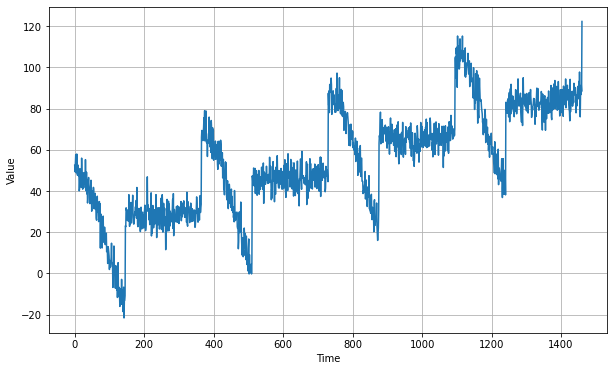

In [23]:
plt.figure(figsize=(10,6))
plot_series(time , series)

In [24]:
# 생성한 데이터를 train 과 valid로 분할
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [26]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [42]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [43]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset , epochs=100, verbose=1)

Epoch 1/100
      1/Unknown - 0s 0s/step - loss: 10623.6084WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0010s). Check your callbacks.
31/31 [==============================] - 1s 35ms/step - loss: 2039.6422
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 211.6641
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 122.6263
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 114.5757
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 108.3625
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 103.3120
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 100.1838
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 97.6497
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 92.0248
Epoch 10/100
31/31 [====================

31/31 [==============================] - 0s 1ms/step - loss: 44.6833
Epoch 98/100
31/31 [==============================] - 0s 804us/step - loss: 44.3640
Epoch 99/100
31/31 [==============================] - 0s 804us/step - loss: 44.9248
Epoch 100/100
31/31 [==============================] - 0s 1ms/step - loss: 44.0522


In [44]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.04603463],
       [ 0.03479459],
       [ 0.02389038],
       [-0.07685281],
       [-0.01785737],
       [ 0.08976291],
       [ 0.06781932],
       [-0.02315763],
       [-0.09882465],
       [ 0.01130129],
       [ 0.05601336],
       [-0.03193796],
       [-0.035875  ],
       [-0.020712  ],
       [ 0.0891024 ],
       [ 0.09768079],
       [ 0.02504436],
       [ 0.11530034],
       [ 0.21774185],
       [ 0.5082586 ]], dtype=float32), array([0.01844797], dtype=float32)]


In [74]:
forecast = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))


In [75]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


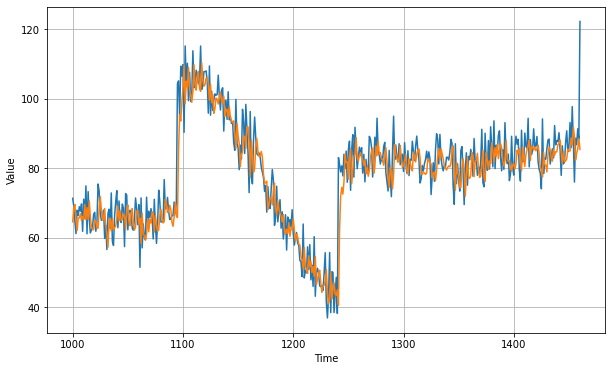

In [76]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [77]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1749225